In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_cnt.csv')

In [ ]:
!unzip -q '../Data/glove.42B.300d.txt.zip'

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
index_to_id_mapping = {index: author_id for index, author_id in enumerate(one_hot_encoder.categories_[0])}

## Embedding matica

In [ ]:
path_to_glove_file = 'glove.42B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 70000
sequence_length = 8000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc[:10]

['', '[UNK]', 's', 'one', 'would', 'upon', 'man', 'could', 'great', 'time']

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 56146 words (13854 misses)


# Modely

## Dense model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 8000, 300)         21000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='_glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 64
epochs = 12

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/12
10/10 [==============================] - 146s 16s/step - loss: 2.8385 - accuracy: 0.0990 - val_loss: 2.7923 - val_accuracy: 0.1061
Epoch 2/12
10/10 [==============================] - 142s 16s/step - loss: 2.6478 - accuracy: 0.1672 - val_loss: 2.6472 - val_accuracy: 0.2121
Epoch 3/12
10/10 [==============================] - 142s 16s/step - loss: 2.4799 - accuracy: 0.1826 - val_loss: 2.4788 - val_accuracy: 0.2727
Epoch 4/12
10/10 [==============================] - 142s 16s/step - loss: 2.2702 - accuracy: 0.3413 - val_loss: 2.3162 - val_accuracy: 0.2879
Epoch 5/12
10/10 [==============================] - 142s 16s/step - loss: 2.0787 - accuracy: 0.4266 - val_loss: 2.1469 - val_accuracy: 0.3182
Epoch 6/12
10/10 [==============================] - 141s 16s/step - loss: 1.8874 - accuracy: 0.4556 - val_loss: 2.0306 - val_accuracy: 0.3939
Epoch 7/12
10/10 [==============================] - 142s 16s/step - loss: 1.6886 - accuracy: 0.5427 - val_loss: 1.7925 - val_accuracy: 0.4697
Epoch 

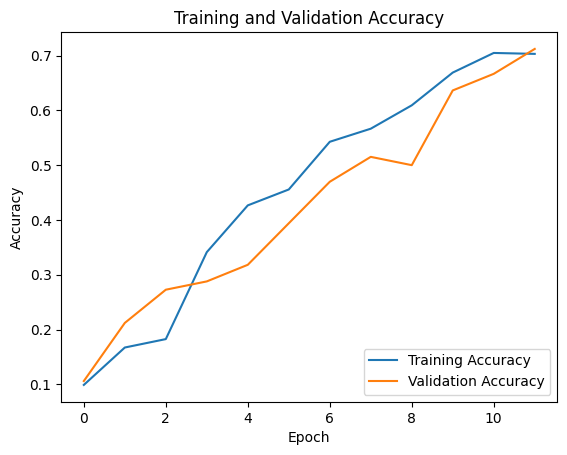

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 0s 33ms/step


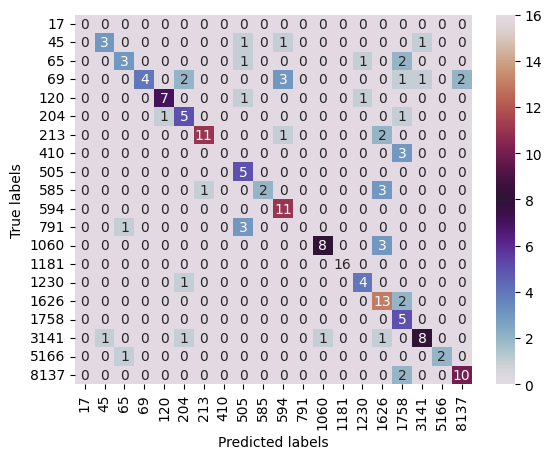

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  1  0  0]
 [ 0  0  3  0  0  0  0  0  1  0  0  0  0  0  1  0  2  0  0  0]
 [ 0  0  0  4  0  2  0  0  0  0  3  0  0  0  0  0  1  1  0  2]
 [ 0  0  0  0  7  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  5  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  1  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  2  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  2  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7134146341463414
F1 Score: 0.6977052308472681
Precision: 0.7577420546932743
Recall: 0.7134146341463414


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 8000, 300)         21000600  
                                                                 
 conv1d (Conv1D)             (None, 7997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 3998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
19/19 [==============================] - 152s 8s/step - loss: 2.7271 - accuracy: 0.1570 - val_loss: 2.5652 - val_accuracy: 0.1667
Epoch 2/15
19/19 [==============================] - 143s 8s/step - loss: 2.2572 - accuracy: 0.2884 - val_loss: 2.1982 - val_accuracy: 0.4242
Epoch 3/15
19/19 [==============================] - 144s 8s/step - loss: 1.9474 - accuracy: 0.4693 - val_loss: 1.9652 - val_accuracy: 0.4848
Epoch 4/15
19/19 [==============================] - 142s 8s/step - loss: 1.6802 - accuracy: 0.5256 - val_loss: 1.7379 - val_accuracy: 0.5909
Epoch 5/15
19/19 [==============================] - 142s 8s/step - loss: 1.4713 - accuracy: 0.5973 - val_loss: 1.5980 - val_accuracy: 0.5758
Epoch 6/15
19/19 [==============================] - 143s 8s/step - loss: 1.2559 - accuracy: 0.6962 - val_loss: 1.4293 - val_accuracy: 0.6061
Epoch 7/15
19/19 [==============================] - 143s 8s/step - loss: 1.1474 - accuracy: 0.6741 - val_loss: 1.2366 - val_accuracy: 0.6818
Epoch 8/15
19

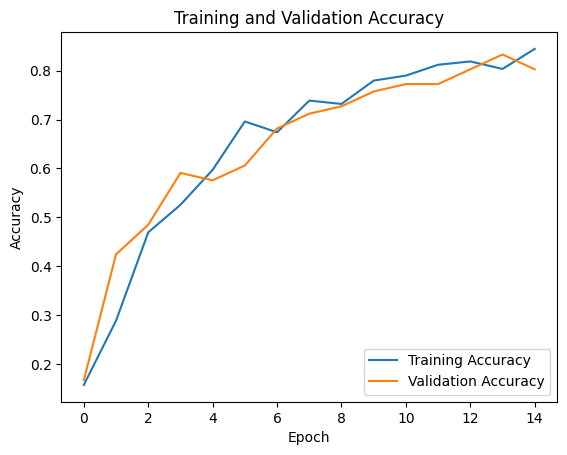

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 0s 58ms/step


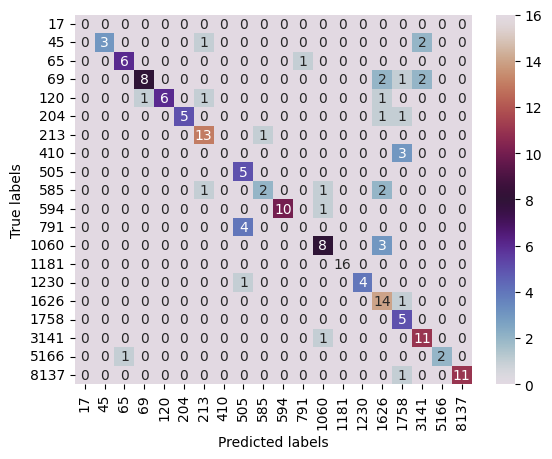

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  2  1  2  0  0]
 [ 0  0  0  1  6  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  2  0  0  1  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  1  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7865853658536586
F1 Score: 0.7755591081629611
Precision: 0.8075873394603511
Recall: 0.7865853658536586


## Biderectional LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 8000, 300)         21000600  
                                                                 
 bidirectional (Bidirection  (None, 8000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
19/19 [==============================] - 154s 8s/step - loss: 2.8408 - accuracy: 0.1109 - val_loss: 2.6971 - val_accuracy: 0.1667
Epoch 2/15
19/19 [==============================] - 151s 8s/step - loss: 2.4909 - accuracy: 0.2184 - val_loss: 2.2758 - val_accuracy: 0.4394
Epoch 3/15
19/19 [==============================] - 150s 8s/step - loss: 2.0621 - accuracy: 0.3771 - val_loss: 1.9367 - val_accuracy: 0.3788
Epoch 4/15
19/19 [==============================] - 151s 8s/step - loss: 1.6851 - accuracy: 0.4881 - val_loss: 1.6213 - val_accuracy: 0.4545
Epoch 5/15
19/19 [==============================] - 9s 501ms/step - loss: 1.4972 - accuracy: 0.5358 - val_loss: 1.6566 - val_accuracy: 0.3788
Epoch 6/15
19/19 [==============================] - 151s 8s/step - loss: 1.3179 - accuracy: 0.5768 - val_loss: 1.3974 - val_accuracy: 0.5152
Epoch 7/15
19/19 [==============================] - 9s 500ms/step - loss: 1.1316 - accuracy: 0.6570 - val_loss: 1.4548 - val_accuracy: 0.5152
Epoch 8/15


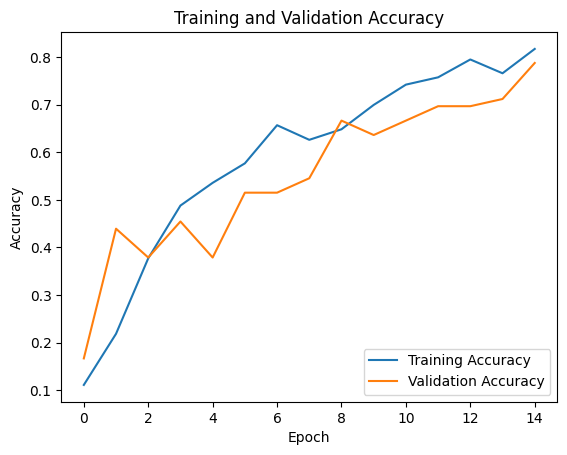

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 223ms/step


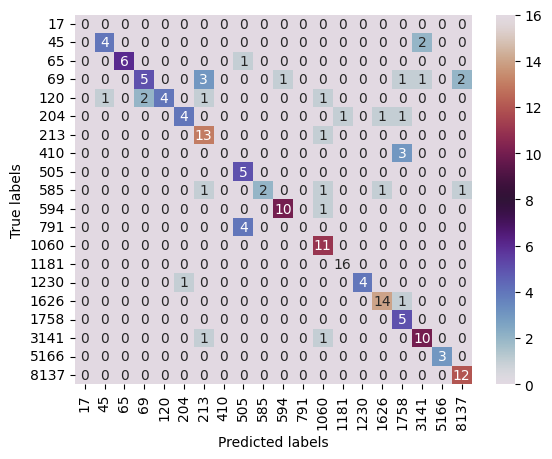

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  6  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  3  0  0  0  1  0  0  0  0  0  1  1  0  2]
 [ 0  1  0  2  4  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0  1  0  1  1  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  2  0  0  1  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  1  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7804878048780488
F1 Score: 0.7546131224386534
Precision: 0.7842346444331927
Recall: 0.7804878048780488


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 8000, 300)         21000600  
                                                                 
 lstm_1 (LSTM)               (None, 8000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 8000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
19/19 [==============================] - 156s 8s/step - loss: 2.9593 - accuracy: 0.0768 - val_loss: 2.9596 - val_accuracy: 0.0606
Epoch 2/10
19/19 [==============================] - 150s 8s/step - loss: 2.8424 - accuracy: 0.1143 - val_loss: 2.9378 - val_accuracy: 0.1364
Epoch 3/10
19/19 [==============================] - 151s 8s/step - loss: 2.6938 - accuracy: 0.1894 - val_loss: 2.9018 - val_accuracy: 0.1061
Epoch 4/10
19/19 [==============================] - 10s 555ms/step - loss: 2.6493 - accuracy: 0.1809 - val_loss: 2.9360 - val_accuracy: 0.1364
Epoch 5/10
19/19 [==============================] - 151s 8s/step - loss: 2.5088 - accuracy: 0.2321 - val_loss: 2.8069 - val_accuracy: 0.1667
Epoch 6/10
19/19 [==============================] - 11s 562ms/step - loss: 2.3649 - accuracy: 0.2457 - val_loss: 2.8879 - val_accuracy: 0.1212
Epoch 7/10
19/19 [==============================] - 10s 554ms/step - loss: 2.2107 - accuracy: 0.3157 - val_loss: 2.8952 - val_accuracy: 0.1212
Epoch 8

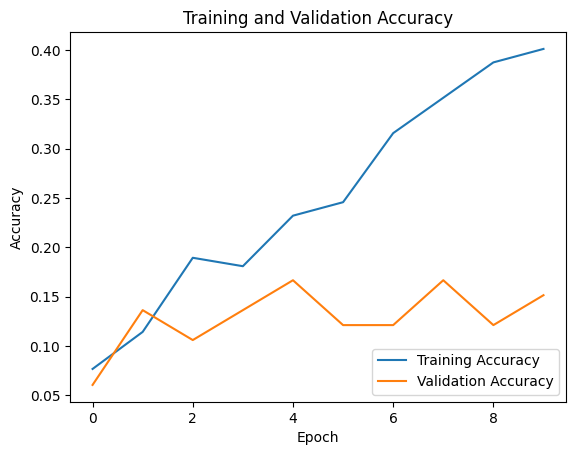

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 235ms/step


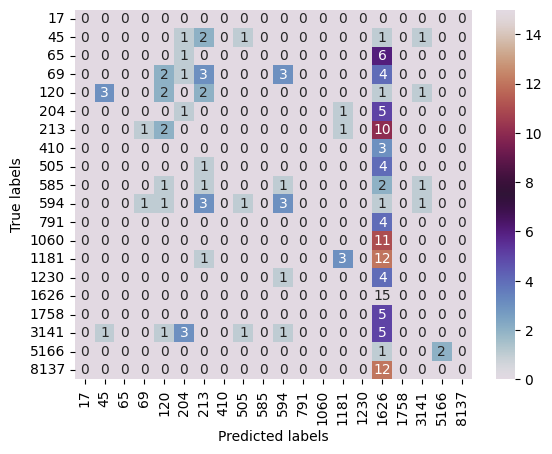

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  0  1  0  0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  2  1  3  0  0  0  3  0  0  0  0  4  0  0  0  0]
 [ 0  3  0  0  2  0  2  0  0  0  0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  5  0  0  0  0]
 [ 0  0  0  1  2  0  0  0  0  0  0  0  0  1  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  1  0  0  0  0  2  0  1  0  0]
 [ 0  0  0  1  1  0  3  0  1  0  3  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  3  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.15853658536585366
F1 Score: 0.10360022460909378
Precision: 0.13042261082988188
Recall: 0.15853658536585366
